In [59]:
import pandas as pd
import os
import glob

In [60]:
filename = 'cluster_36-cialis_ game_ dysfunction.json'
path = './lda_clustered_json/'+filename
 
with open(path, encoding='utf-8', mode='r') as currentFile:
    df = pd.read_json(currentFile, orient='index')

df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext
9,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 13:09:27","By Tim Lister, CNN Call it the flip-side to to...",en,security.blogs.cnn.com,"By Tim Lister, CNN Call it the flip-side to to...",Sex and espionage: A long and sordid history –...,https://security.blogs.cnn.com/2012/04/18/sex-...,36,0.94926,"cialis, game, dysfunction, president, denver, ...",tim lister call torture seduction old testamen...
17,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:18:51","Trending: Kathryn Scott, The Denver Post Fred ...",en,www.denverpost.com,"Trending: Kathryn Scott, The Denver Post Fred ...",How an Ecuadorian rose makes the journey to yo...,https://www.denverpost.com/2018/02/09/valentin...,36,0.99204,"cialis, game, dysfunction, president, denver, ...",trending kathryn scott denver fred michel amat...
103,"07/14/2021, 01:17:06","07/14/2021, 01:17:06","06/13/2021, 20:59:36",Many of the Heisman previews I've read in year...,en,pittsburgh.cbslocal.com,Many of the Heisman previews I've read in year...,The Heisman Horseman: Who Should Win – CBS Pit...,https://pittsburgh.cbslocal.com/2011/12/09/the...,36,0.57907,"cialis, game, dysfunction, president, denver, ...",heisman finalist contestant beauty contest oft...


In [61]:
amount_of_articles = len(df["filtered_maintext"])
print(f"Amount of articles: {amount_of_articles}")
processed_articles = df['filtered_maintext']

Amount of articles: 6


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(max_features=2000, min_df=0.3 , max_df=0.7)  
tfidf = tfidfconverter.fit_transform(processed_articles)
print(tfidf)

  (0, 749)	0.014729370005675662
  (0, 549)	0.014729370005675662
  (0, 382)	0.014729370005675662
  (0, 7)	0.014729370005675662
  (0, 511)	0.014729370005675662
  (0, 151)	0.014729370005675662
  (0, 270)	0.014729370005675662
  (0, 601)	0.014729370005675662
  (0, 211)	0.014729370005675662
  (0, 619)	0.014729370005675662
  (0, 165)	0.014729370005675662
  (0, 517)	0.017446305626564188
  (0, 133)	0.014729370005675662
  (0, 607)	0.014729370005675662
  (0, 112)	0.014729370005675662
  (0, 762)	0.017446305626564188
  (0, 360)	0.034892611253128376
  (0, 536)	0.017446305626564188
  (0, 28)	0.017446305626564188
  (0, 771)	0.014729370005675662
  (0, 324)	0.014729370005675662
  (0, 521)	0.017446305626564188
  (0, 35)	0.017446305626564188
  (0, 591)	0.017446305626564188
  (0, 588)	0.014729370005675662
  :	:
  (5, 539)	0.041678090745095
  (5, 192)	0.041678090745095
  (5, 768)	0.04936590694581096
  (5, 21)	0.04936590694581096
  (5, 332)	0.04936590694581096
  (5, 542)	0.041678090745095
  (5, 273)	0.041678

In [63]:
from sklearn.metrics.pairwise import cosine_distances

cosine_similarity = cosine_distances(tfidf)
cosine_similarity

array([[0.        , 0.97290322, 0.99352988, 0.3137372 , 0.79434151,
        0.94625384],
       [0.97290322, 0.        , 0.93970339, 0.97022509, 0.96872373,
        0.97033323],
       [0.99352988, 0.93970339, 0.        , 0.97458998, 0.94675479,
        0.9908547 ],
       [0.3137372 , 0.97022509, 0.97458998, 0.        , 0.3509157 ,
        0.98601593],
       [0.79434151, 0.96872373, 0.94675479, 0.3509157 , 0.        ,
        0.98368908],
       [0.94625384, 0.97033323, 0.9908547 , 0.98601593, 0.98368908,
        0.        ]])

In [64]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(affinity='precomputed', damping=0.5, random_state=5)
clustering.fit(cosine_similarity)
labels = clustering.labels_
print(labels.dtype)
#cluster_centers = clustering.cluster_centers_
cluster_centers_indices = clustering.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

int64


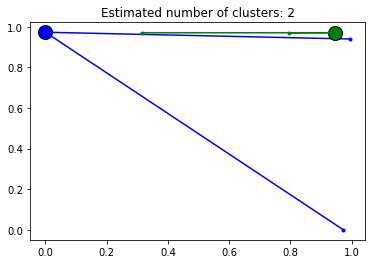

In [65]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cosine_similarity[cluster_centers_indices[k]]
    plt.plot(cosine_similarity[class_members, 0], cosine_similarity[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in cosine_similarity[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [66]:
df['processed_articles'] = processed_articles
df['affpropID'] = clustering.labels_
df.head()

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext,processed_articles,affpropID
9,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 13:09:27","By Tim Lister, CNN Call it the flip-side to to...",en,security.blogs.cnn.com,"By Tim Lister, CNN Call it the flip-side to to...",Sex and espionage: A long and sordid history –...,https://security.blogs.cnn.com/2012/04/18/sex-...,36,0.94926,"cialis, game, dysfunction, president, denver, ...",tim lister call torture seduction old testamen...,tim lister call torture seduction old testamen...,0
17,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:18:51","Trending: Kathryn Scott, The Denver Post Fred ...",en,www.denverpost.com,"Trending: Kathryn Scott, The Denver Post Fred ...",How an Ecuadorian rose makes the journey to yo...,https://www.denverpost.com/2018/02/09/valentin...,36,0.99204,"cialis, game, dysfunction, president, denver, ...",trending kathryn scott denver fred michel amat...,trending kathryn scott denver fred michel amat...,0
103,"07/14/2021, 01:17:06","07/14/2021, 01:17:06","06/13/2021, 20:59:36",Many of the Heisman previews I've read in year...,en,pittsburgh.cbslocal.com,Many of the Heisman previews I've read in year...,The Heisman Horseman: Who Should Win – CBS Pit...,https://pittsburgh.cbslocal.com/2011/12/09/the...,36,0.57907,"cialis, game, dysfunction, president, denver, ...",heisman finalist contestant beauty contest oft...,heisman finalist contestant beauty contest oft...,0
146,"07/14/2021, 01:25:06","07/14/2021, 01:25:06","06/14/2021, 02:05:45",Two years after exposing slavery in the cocoa ...,en,thecnnfreedomproject.blogs.cnn.com,Two years after exposing slavery in the cocoa ...,Cocoa-nomics: Watch the documentary in full – ...,https://thecnnfreedomproject.blogs.cnn.com/201...,36,0.59855,"cialis, game, dysfunction, president, denver, ...",slavery cocoa plantation ivory coast team choc...,slavery cocoa plantation ivory coast team choc...,1
166,"07/14/2021, 01:29:02","07/14/2021, 01:29:02","06/14/2021, 05:18:36",READ about Piers Morgan's long career in journ...,en,piersmorgan.blogs.cnn.com,READ about Piers Morgan's long career in journ...,Rick Warren on his late son: Matthew was not a...,https://piersmorgan.blogs.cnn.com/2013/09/17/r...,36,0.65960,"cialis, game, dysfunction, president, denver, ...",piers morgan career journalism christian pasto...,piers morgan career journalism christian pasto...,1
